# Классификация тональности комментариев

## Загрузка библиотек и файлов

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk, spacy
from nltk.corpus import stopwords
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    f1_score, precision_score, recall_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, precision_recall_curve, average_precision_score,
    PrecisionRecallDisplay, roc_curve, RocCurveDisplay, auc
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

import requests
from fastapi import FastAPI
from pydantic import BaseModel
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим файл с комментариями из группы Vkontakte
data = pd.read_csv('/Users/lena/Comment Sentiment Classification/vk_comments_data.csv')
data

,text,label
0,.... ведь одна из этих дорог ведёт в ваше серд...,neutral
1,"…лучше в ВК, я редко захожу…",neutral
2,"""- Мама, купи Seti! - У нас есть Сети дома. Се...",neutral
3,"""— Знаешь, откуда эти шрамы?©""",neutral
4,""""""" Kinfire — к сожалению, сдвигается на февра...",negative
...,...,...
2216,Я удалила приложение вайлдберриз после несколь...,negative
2217,Я уж думал не дождёмся! 😱,negative
2218,"Я что-то пропустил, а коробки Ascension Tactic...",neutral
2219,я чуть себе усложнил),neutral


## Предобработка и исследовательский анализ данных

In [3]:
# Посмотрим информацию о файле
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2221 non-null   object
 1   label   2221 non-null   object
dtypes: object(2)
memory usage: 34.8+ KB


Датасет содержит 2 колонки и 2221 комментарий 

- text - текст комментария
- label - тональность комментария (neutral, positive, negative)

In [4]:
# Проверим датасет на явные дубли
data.duplicated().sum()

np.int64(10)

In [5]:
# Удалим явные дубли
data = data.drop_duplicates()

<Axes: xlabel='label', ylabel='count'>

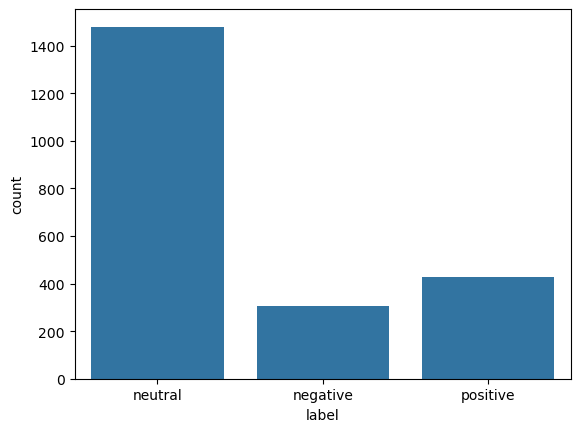

In [6]:
# Проверим баланс целевой переменной 'label'
sns.countplot(data=data, x = 'label')

In [7]:
data['label'].value_counts()

label
neutral     1479
positive     426
negative     306
Name: count, dtype: int64

В целевой переменной label наблюдается дисбаланс классов: нейтральных комментариев значительно больше (1479), чем позитивных (426) и негативных (306).

Этот дисбаланс необходимо учесть при обучении моделей.

### Предобработке текстовых данных

**Перейдем к предобработке текстовых данных - столбец 'text'.**

* Очистим текст. Удалим специальные символы, цифры и пр., которые не являются буквами.

* Проведем лемматизацию, то есть приведем слова к их базовой форме (лемме). Это поможет уменьшить размерность и учесть различные формы слова.

* Удалим стоп-слова (russian), которые обычно не несут смысловой нагрузки (напримпер, союзы, предлоги).

* Учтем части речи (существительные, глаголы, прилагательные и наречия). Лемматизация с учетом частей речи может улучшить качество предобработки, учитывая контекст использования слов.

Напишем для каждого шага отдельные функции и применим к столбцу 'text'

In [8]:
# Скачиваем стоп-слова для русского языка
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

# Загружаем русскую модель spaCy
nlp = spacy.load('ru_core_news_sm', disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to /Users/lena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Очищаем текст от лишних символов
def clean_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'[^а-яёa-z0-9\s]', ' ', text)  # Удаление всех символов, кроме букв
    return text

In [10]:
# Проводим лемматизация с учетом частей речи (для русского языка)
def lemmatize_with_pos(text):
    doc = nlp(text.lower())
    lemmatized_text = []
    for token in doc:
        if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']:  
            lemmatized_text.append(token.lemma_)
    return ' '.join(lemmatized_text)


# Пример
examples = [
    'Мможете посмотреть на The Voynich Puzzle?',
    'Игра отличная, спасибо большое!',
    'А рассрочка где?',
    'Цены грабительские!',
    'Быстро доставили, всё понравилось 👍'
]

for ex in examples:
    print(ex, '-', lemmatize_with_pos(ex))

Мможете посмотреть на The Voynich Puzzle? - мможете посмотреть
Игра отличная, спасибо большое! - игра отличный спасибо большой
А рассрочка где? - рассрочка где
Цены грабительские! - цена грабительский
Быстро доставили, всё понравилось 👍 - быстро доставить понравиться


In [11]:
# Удалим стоп-слова
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in russian_stopwords])

In [12]:
# Соберем все функции вместе

def preprocess_text(text, remove_stops=True):
    cleaned_text = clean_text(text)
    lemmatized_text = lemmatize_with_pos(cleaned_text)
    if remove_stops:
        final_text = remove_stopwords(lemmatized_text)
    else:
        final_text = lemmatized_text
    return final_text

# Пример
examples = [
    'Можете посмотреть на The Voynich Puzzle?',
    'Игра отличная, спасибо большое!',
    'А рассрочка где?',
    'Цены грабительские!',
    'Быстро доставили, всё понравилось 👍'
]

for ex in examples:
    print(ex, '-', preprocess_text(ex))

Можете посмотреть на The Voynich Puzzle? - мочь посмотреть
Игра отличная, спасибо большое! - игра отличный спасибо большой
А рассрочка где? - рассрочка
Цены грабительские! - цена грабительский
Быстро доставили, всё понравилось 👍 - быстро доставить понравиться


In [13]:
# Подключаем прогресс-бар
tqdm.pandas()

# Применяем функцию предобработки к каждому тексту
data['text'] = data['text'].progress_apply(preprocess_text)

100%|██████████████████████████████████████| 2211/2211 [00:17<00:00, 129.45it/s]


In [14]:
# Проверяем результат предобработки
data.head()

,text,label
0,дорога ведёт сердечко,neutral
1,хороший редко заходить,neutral
2,мама купи сеть дом сеть дом,neutral
3,знать откуда шрамы,neutral
4,сожаление сдвигаться февраль очень плохо спасибо,negative


In [15]:
# Еще раз проверим датасет на явные дубликаты
data.duplicated().sum()

np.int64(144)

In [16]:
# Удалим явные дубли
data = data.drop_duplicates()

In [17]:
# Итоговый датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2067 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2067 non-null   object
 1   label   2067 non-null   object
dtypes: object(2)
memory usage: 48.4+ KB


После предобработки в датасете осталось 2067 строк.

Разделим данные на обучающую и тестовую выборки

In [18]:
X = data.drop('label', axis=1)
y = data['label']

In [19]:
# Разделим данные на обучающую и тестовую выборки с сохранением баланса классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=0,
    stratify=y  # сохраняем соотношение классов
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1653, 1) (414, 1) (1653,) (414,)


### Вывод

На этапе предобработки и исследовательского анализа:

* Проверили данные на пропуски и явные дубликаты

* Обработали текстовые данные в столбеце 'text':

    * Очистили текст от специальных символов, цифр и пр.
    * Привели слова к их базовой форме (лемме).
    * Учли части речи (существительные, глаголы, прилагательные и наречия).

* Разделили данные на тренировочную и тестовую выборки

## Обучение моделей с использованием Pipeline и GridSearchCV

Предстоит решить задачу **многоклассовой классификации**: определить тональность комментариев пользователей на три категории: neutral, positive и negative.

**Цель**:
Разработать модель, способную корректно классифицировать комментарии, учитывая дисбаланс классов и различную частотность позитивных, негативных и нейтральных сообщений.

**Особенности данных**:

- Наблюдается дисбаланс классов: нейтральных комментариев значительно больше, чем позитивных и негативных.

- Данные представлены текстовыми комментариями, которые необходимо преобразовать в числовой формат для обучения моделей.

**Оценка качества моделей**:

Для оценки качества моделей предлагается использовать метрику **F1-macro**, которая учитывает производительность классификатора по всем классам равномерно, независимо от их частоты.

F1-macro вычисляется по каждому классу отдельно, затем берётся среднее арифметическое, без учёта количества объектов в классе. F1-macro даст одинаковый вес каждому классу, что важно при дисбалансе, чтобы маленькие классы (positive, negative) не терялись в оценке.

Для решения задачи обучим на тренировочной выборке несколько моделей машинного обучения:

* LogisticRegression
* ComplementNB
* LinearSVC
* RidgeClassifier
* CatBoostClassifier

Для работы с текстовыми комментариями и дисбалансом классов используются два подхода:

- Использование **ImbPipeline** с **SMOTE**:


В этом пайплайне текстовые данные преобразуются с помощью TF-IDF (TfidfVectorizer), затем полученная разреженная матрица конвертируется в плотный формат (FunctionTransformer), и после этого применяется SMOTE для синтетического увеличения количества примеров в меньших классах. Это позволяет моделям обучаться на сбалансированных данных.

- Использование обычного **Pipeline** с **весами для классов**:
  
В этом подходе текстовые данные также преобразуются с помощью TF-IDF, но дисбаланс учитывается через веса для каждого примера (**compute_sample_weight**). Такие веса передаются непосредственно модели на этапе обучения.

In [20]:
# Список для сбора результатов
results = []

In [21]:
def to_dense(x):
    return np.asarray(x.todense())

### LogisticRegression

**LogisticRegression**

- Простая и интерпретируемая модель.
- Хорошо работает для текстовых данных с TF-IDF признаками.
- Подходит для многоклассовой классификации через стратегию one-vs-rest

In [22]:
# Pipeline
lr_smote_pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(solver='liblinear', max_iter=2000))
])

# Параметры для GridSearchCV
lr_smote_param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10]
}

# GridSearchCV
lr_smote_grid = GridSearchCV(
    lr_smote_pipeline,
    param_grid=lr_smote_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Обучение
lr_smote_grid.fit(X_train['text'], y_train)

# Сохранение результатов
lr_smote_best_params = lr_smote_grid.best_params_
lr_smote_best_score = lr_smote_grid.best_score_

results.append({
    'Model': 'LogisticRegression',
    'Best F1-macro (CV)': lr_smote_best_score,
    'Best Params': lr_smote_best_params
})

print(f"Лучшие параметры LR+SMOTE: {lr_smote_best_params}")
print(f"Лучшая F1-макро на кросс-валидации LR+SMOTE: {lr_smote_best_score:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/lena/opt/anaconda3/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lena/opt/anaconda3/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lena/opt/anaconda3/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lena/opt/anaconda3/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Лучшие параметры LR+SMOTE: {'clf__C': 1, 'clf__penalty': 'l1'}
Лучшая F1-макро на кросс-валидации LR+SMOTE: 0.6124


### ComplementNB

**ComplementNB**

- Байесовская модель, специально созданная для работы с текстовыми данными.
- Эффективна для больших разреженных матриц, таких как TF-IDF.
- Корректирует дисбаланс классов.

In [23]:
# Pipeline
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model_nb', ComplementNB())
])

# Параметры для GridSearchCV
param_nb = {
    'model_nb__alpha': [0.1, 0.5, 1.0],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

# GridSearchCV
grid_nb = GridSearchCV(
    pipeline_nb,
    param_grid=param_nb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Веса для каждого примера (чтобы учесть дисбаланс)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Обучение
grid_nb.fit(X_train['text'], y_train, model_nb__sample_weight=sample_weights)

# Сохранение результатов
nb_best_params = grid_nb.best_params_
nb_best_score = grid_nb.best_score_

results.append({
    'Model': 'ComplementNB',
    'Best F1-macro (CV)': nb_best_score,
    'Best Params': nb_best_params
})

print(f"Лучшие параметры ComplementNB: {nb_best_params}")
print(f"Лучшая F1-макро на кросс-валидации ComplementNB: {nb_best_score:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры ComplementNB: {'model_nb__alpha': 0.5, 'tfidf__ngram_range': (1, 2)}
Лучшая F1-макро на кросс-валидации ComplementNB: 0.5490


### LinearSVC

**LinearSVC**

- Хорошо справляется с высокоразмерными признаковыми пространствами, как у TF-IDF.
- Хорошо масштабируется на большие объёмы текстовых данных.

In [24]:
# Pipeline
svc_smote_pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(random_state=42, max_iter=5000))
])

# Параметры для GridSearchCV
svc_smote_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__loss': ['hinge', 'squared_hinge'],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

# GridSearchCV
svc_smote_grid = GridSearchCV(
    svc_smote_pipeline,
    param_grid=svc_smote_param_grid,
    cv=5,
    scoring='f1_macro', 
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Обучение
svc_smote_grid.fit(X_train['text'], y_train)

# # Сохранение результатов
svc_smote_best_params = svc_smote_grid.best_params_
svc_smote_best_score = svc_smote_grid.best_score_

results.append({
    'Model': 'LinearSVC',
    'Best F1-macro (CV)': svc_smote_best_score,
    'Best Params': svc_smote_best_params
})

print(f"Лучшие параметры LinearSVC+SMOTE: {svc_smote_best_params}")
print(f"Лучшая F1-макро на кросс-валидации LinearSVC+SMOTE: {svc_smote_best_score:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/lena/opt/anaconda3/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lena/opt/anaconda3/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lena/opt/anaconda3/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lena/opt/anaconda3/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lena/opt/anaconda3/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lena/opt/anaconda3/anac

Лучшие параметры LinearSVC+SMOTE: {'clf__C': 1, 'clf__loss': 'hinge', 'tfidf__ngram_range': (1, 2)}
Лучшая F1-макро на кросс-валидации LinearSVC+SMOTE: 0.6185


### RidgeClassifier

**RidgeClassifier**

- Линейная модель с регуляризацией, устойчивой к переобучению.
- Быстро обучается, подходит для задач с разреженными признаками.

In [25]:
# Pipeline
ridge_smote_pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)),
    ('smote', SMOTE(random_state=42)),
    ('clf', RidgeClassifier())
])

# Параметры для GridSearchCV
ridge_smote_param_grid = {
    'clf__alpha': [0.1, 1, 10, 100],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

# GridSearchCV
ridge_smote_grid = GridSearchCV(
    ridge_smote_pipeline,
    param_grid=ridge_smote_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Обучение
ridge_smote_grid.fit(X_train['text'], y_train)

# Сохранение результатов
ridge_smote_best_params = ridge_smote_grid.best_params_
ridge_smote_best_score = ridge_smote_grid.best_score_

results.append({
    'Model': 'RidgeClassifier',
    'Best F1-macro (CV)': ridge_smote_best_score,
    'Best Params': ridge_smote_best_params
})

print(f"Лучшие параметры RidgeClassifier+SMOTE: {ridge_smote_best_params}")
print(f"Лучшая F1-макро на кросс-валидации RidgeClassifier+SMOTE: {ridge_smote_best_score:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры RidgeClassifier+SMOTE: {'clf__alpha': 1, 'tfidf__ngram_range': (1, 2)}
Лучшая F1-макро на кросс-валидации RidgeClassifier+SMOTE: 0.6166


### CatBoostClassifier

**CatBoostClassifier**

- Хорошо справляется с дисбалансом классов через параметр class_weights.
- Часто даёт лучшие показатели на сложных, несбалансированных наборах данных.

In [26]:
# Рассчитаем веса для каждого класса
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = class_weights.tolist()
print("Class weights:", class_weights)

# Pipeline с CatBoost
pipeline_cb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model_cb', CatBoostClassifier(
        random_state=42,
        verbose=0,
        class_weights=class_weights
    ))
])

# Параметры для GridSearchCV
param_cb = {
    'model_cb__iterations': [100, 200],
    'model_cb__learning_rate': [0.05, 0.1],
    'model_cb__depth': [3, 4, 5],
    'model_cb__l2_leaf_reg': [1, 3, 5]
}

# GridSearchCV
grid_cb = GridSearchCV(
    pipeline_cb,
    param_grid=param_cb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Обучение
grid_cb.fit(X_train['text'], y_train)

# Сохранение результатов
best_params_cb = grid_cb.best_params_
best_score_cb = grid_cb.best_score_

results.append({
    'Model': 'CatBoostClassifier',
    'Best F1-macro (CV)': best_score_cb,
    'Best Params': best_params_cb
})

print(f'\nЛучшие параметры CatBoostClassifier: {best_params_cb}')
print(f'Лучшая оценка F1-меры: {best_score_cb:.4f}')

Class weights: [2.3151260504201683, 0.5009090909090909, 1.7492063492063492]
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Лучшие параметры CatBoostClassifier: {'model_cb__depth': 4, 'model_cb__iterations': 200, 'model_cb__l2_leaf_reg': 1, 'model_cb__learning_rate': 0.1}
Лучшая оценка F1-меры: 0.5743


In [27]:
# Создаем DataFrame и выводим результаты обучения на тренировочной выборке
pd.set_option('display.max_colwidth', None)

results_data = pd.DataFrame(results)
display(results_data)

,Model,Best F1-macro (CV),Best Params
0,LogisticRegression,0.612399,"{'clf__C': 1, 'clf__penalty': 'l1'}"
1,ComplementNB,0.548979,"{'model_nb__alpha': 0.5, 'tfidf__ngram_range': (1, 2)}"
2,LinearSVC,0.618532,"{'clf__C': 1, 'clf__loss': 'hinge', 'tfidf__ngram_range': (1, 2)}"
3,RidgeClassifier,0.616625,"{'clf__alpha': 1, 'tfidf__ngram_range': (1, 2)}"
4,CatBoostClassifier,0.574324,"{'model_cb__depth': 4, 'model_cb__iterations': 200, 'model_cb__l2_leaf_reg': 1, 'model_cb__learning_rate': 0.1}"


Наилучшие результаты на тренировочной выборке показала модель LinearSVC (F1-macro = 0.6185). Именно её будем использовать для предсказания тональности комментариев на тестовой выборке.

### Вывод

**На этапе обучения моделей были проверены 5 алгоритмов машинного обучения**:

- Logistic Regression
- ComplementNB
- LinearSVC
- RidgeClassifier
- CatBoostClassifier

Для каждой модели подобраны оптимальные гиперпараметры с использованием **GridSearchCV**. Качество оценивалось по метрике **F1-macro**, которая учитывает баланс между классами в многоклассовой задаче классификации тональности комментариев.

Для работы с текстовыми комментариями и дисбалансом классов использовались два подхода: **ImbPipeline с SMOTE**, который синтетически увеличивает количество примеров в меньших классах после преобразования текста TF-IDF в плотный формат, и обычный **Pipeline с весами для классов**, где дисбаланс учитывался через веса для каждого примера (compute_sample_weight).

Результаты показали, что наилучшие показатели на тренировочной выборке демонстрирует **LinearSVC** с **F1-macro = 0.6185**, немного уступают RidgeClassifier (0.6166) и LogisticRegression (0.6124). Модели на основе наивного Байеса (ComplementNB) и градиентного бустинга (CatBoostClassifier) показали относительно низкие значения F1-macro, что может быть связано с небольшим размером обучающей выборки.

Таким образом, LinearSVC была выбрана для дальнейшего тестирования на отложенной выборке и предсказания тональности комментариев, так как она показала наилучший баланс между точностью и полнотой для всех классов.

## Проверка модели на адекватность (DummyClassifier)

Для проверки адекватности модели на тренировочных данных используем DummyClassifier, который предсказывает классы случайным образом или по частоте.

Это позволяет убедиться, что наша обученная модель действительно извлекает полезную информацию из признаков и показывает улучшение по сравнению с простым предсказателем

In [28]:
# Dummy-модель: всегда предсказывает самый частый класс
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train['text'], y_train)

# Предсказания на трейне
y_dummy_pred = dummy.predict(X_train['text'])

# Метрика F1-macro
f1_dummy = f1_score(y_train, y_dummy_pred, average='macro')
print(f"F1-macro DummyClassifier (train): {f1_dummy:.4f}")

F1-macro DummyClassifier (train): 0.2664


Сравнение с DummyClassifier показывает, что модель значительно превосходит случайное угадывание, что подтверждает её адекватность и способность выделять закономерности в данных.

## Финальное предсказание на тестовой выборке

F1-macro на тесте: 0.5816
              precision    recall  f1-score   support

    negative       0.46      0.38      0.42        60
     neutral       0.80      0.79      0.79       275
    positive       0.50      0.57      0.53        79

    accuracy                           0.69       414
   macro avg       0.59      0.58      0.58       414
weighted avg       0.69      0.69      0.69       414



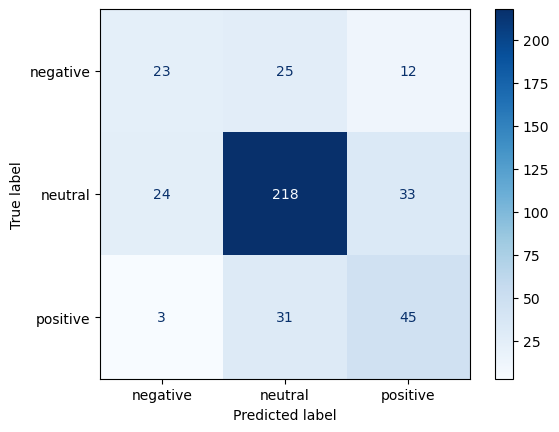

In [29]:
best_model = svc_smote_grid.best_estimator_
tfidf = best_model.named_steps['tfidf']
clf = best_model.named_steps['clf']

X_test_vect = tfidf.transform(X_test['text'])
y_pred = clf.predict(X_test_vect)

print(f"F1-macro на тесте: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['negative','neutral','positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','neutral','positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Лучшая модель (LinearSVC) была протестирована на отложенной тестовой выборке, результаты оценены с помощью метрик F1-macro, precision-macro и recall-macro:

- F1-macro: 0.58
- Precision-macro: 0.59
- Recall-macro: 0.58

Из отчёта классификации и матрицы ошибок видно:

- Модель лучше всего справляется с предсказанием нейтральных комментариев (precision = 0.79, recall = 0.79).
- Для позитивных и негативных комментариев качество ниже: модель часто путает эти классы между собой и с нейтральным.

Это объясняется дисбалансом классов: нейтральных комментариев значительно больше, чем позитивных и негативных, что затрудняет точное предсказание меньших классов.

Итог: модель демонстрирует удовлетворительное качество предсказания для основной (нейтральной) категории, но требует дальнейшей доработки или подбора методов балансировки данных для улучшения распознавания менее представленных классов.

## График Precision-Recall Curve

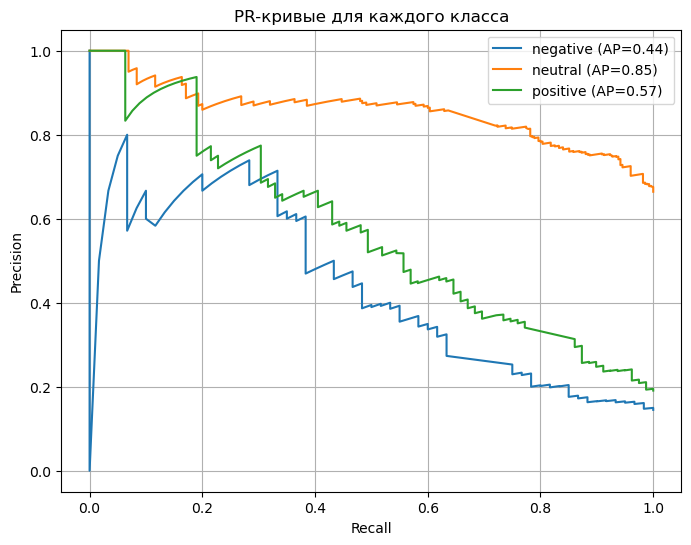

In [30]:
y_score = best_model.decision_function(X_test['text'].values)
classes = best_model.classes_

plt.figure(figsize=(8,6))

for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve((y_test == class_label).astype(int), y_score[:, i])
    ap = average_precision_score((y_test == class_label).astype(int), y_score[:, i])
    plt.plot(recall, precision, label=f'{class_label} (AP={ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривые для каждого класса')
plt.legend()
plt.grid(True)
plt.show()

**negative**

- При recall ≈0, precision≈1 модель выделяет очень немного «негативов», но делает это почти безошибочно.
- При recall ≈0.2 precision держится на уровне 0.7 - модель всё ещё довольно точная.
- После recall ≈0.4 точность резко падает - значит, модель начинает "захватывать" много лишнего и путает негатив с другими классами.

Модель хорошо выделяет самые «очевидные» негативные комментарии, но при расширении выборки точность быстро падает.

**neutral**

- При recall до ≈0.6 precision остаётся высоким ≈1-0.7. Это значит, что модель уверенно выделяет нейтральные комментарии.
- При recall ≈0.6 начинается падение. Чем больше модель старается захватить все нейтральные комментарии, тем больше путает с другими классами.

Нейтральные комментарии для модели самые лёгкие, она классифицирует их лучше всего.

**positive**

- При низком recall ≈0.2 precision падает - модель слабо выделяет позитив.
- Кривая идёт вниз (мало объектов в выборке)

Определение позитивных комментариев для модели — самый трудный класс. В тестовой выборке мало данных и/или фразы часто похожи на нейтральные.

**Average Precision (AP)** в легенде — «площадь под кривой» (чем выше, тем лучше).
У negative и positive классов AP низкий, это сигнал, чтобы:

- добавить больше обучающих данных этого класса
- доработать признаки (например, добавить новые признаки, извлечь признаки из текста).

## Проверка важности признаков (Feature Importances)

Проверим, насколько адекватно выбранная модель различает тональности.

Анализ feature importances полезен для:

- интерпретации работы модели (какие слова сильнее всего влияют на классификацию);

- ручной проверки — нет ли случайных или «шумных» слов среди ключевых признаков;

- дальнейшей доработки словаря (например, объединение синонимов или очистка неинформативных слов).

In [31]:
# Берём лучшую модель из GridSearchCV
best_model = svc_smote_grid.best_estimator_

# Извлекаем признаки и коэффициенты
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
coef = best_model.named_steps['clf'].coef_

# Топ-10 слов для каждого класса
for i, class_label in enumerate(best_model.classes_):
    top10_idx = np.argsort(coef[i])[-10:][::-1]
    top10_words = feature_names[top10_idx]
    top10_weights = coef[i][top10_idx]
    print(f"\nТоп-10 слов для класса '{class_label}':")
    for word, weight in zip(top10_words, top10_weights):
        print(f"{word}: {weight:.3f}")


Топ-10 слов для класса 'negative':
жаль: 2.428
рассрочка: 2.250
дорого: 2.113
отправить: 2.034
хотеть взять: 1.803
странный: 1.740
уродство: 1.719
отписка: 1.719
мде: 1.719
злой: 1.719

Топ-10 слов для класса 'neutral':
карта: 1.857
подсказать: 1.629
планироваться: 1.280
коробка: 1.274
смысл: 1.254
проводить: 1.236
ждать коробочка: 1.207
мочь: 1.178
новый: 1.165
вопрос: 1.142

Топ-10 слов для класса 'positive':
спасибо: 3.234
хороший: 2.473
шикарный: 2.088
очень: 2.069
отличный: 1.941
любимый: 1.896
ура: 1.865
классный: 1.798
шура: 1.755
крутой: 1.739


Модель адекватно выделяет ключевые маркеры классов: негативные - жалобы, нейтральные - вопросы, позитивные - благодарность/похвала.

Набор топ-слов показывает, что модель учится не просто случайным корреляциям, а реально смысловым сигналам, соответствующим человеческому восприятию.

## Проверка модели на новых данных

In [32]:
# Сохраняем TF-IDF и классификатор отдельно
with open('best_model_tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('best_model_clf.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [33]:
# Загружаем отдельно TF-IDF и классификатор
with open("best_model_tfidf.pkl", "rb") as f:
    tfidf = pickle.load(f)

with open("best_model_clf.pkl", "rb") as f:
    clf = pickle.load(f)

In [34]:
# Использование модели на новых данных
new_data = pd.DataFrame(
    {'text': ['спасибо! все шикарно']}
)

X_new_vect = tfidf.transform(new_data['text'])
predictions = clf.predict(X_new_vect)

print("Predicted class:", predictions)

Predicted class: ['positive']


## Тест API

In [35]:
app = FastAPI()

class Texts(BaseModel):
    text: list[str]

@app.post("/predict_model")
def predict_model(texts: Texts):
    # Преобразуем тексты в векторы
    X_vect = tfidf.transform(texts.text)
    # Предсказания
    preds = clf.predict(X_vect)
    return {"predictions": preds.tolist()}

data = {"text": ["Ура, спасибо вам, все шикарно!"]}
prediction = requests.post("http://127.0.0.1:8000/predict_model", json=data).json()
print(prediction)

{'predictions': ['positive']}


## Вывод

В рамках проекта была решена **задача многоклассовой классификации текстовых комментариев** пользователей на три категории:
- neutral
- positive
- negative

**В процессе исследования**:

- Сформирован датасет комментариев, собранных с помощью Python-парсера и VK API из публичной группы;
- Данные размечены вручную
- Проведена предобработка данных (очистка текста, лемматизация, учёт частей речи).
- Выявлен дисбаланс классов (большинство комментариев — нейтральные, меньше всего — негативные).
- Преобразованы данные с помощью TF-IDF и разделены на тренировочную и тестовую выборки.
- Для борьбы с дисбалансом применялись два подхода:
    
    - SMOTE (oversampling) в ImbPipeline.
    - Взвешивание классов через compute_sample_weight
  
- Обучены и протестированы модели:
    
    - Logistic Regression
    - ComplementNB
    - LinearSVC
    - RidgeClassifier
    - CatBoostClassifier
   
- Подбор гиперпараметров проводился с помощью GridSearchCV, оценка качества — по метрике F1-macro.

**Результаты моделирования**:

- Лучшая модель — LinearSVC, показала на кросс-валидации F1-macro ≈ 0.62.
- Метрики на тестовой выборке:

    - Accuracy: 0.69
    - F1-macro: 0.58
    - Precision-macro: 0.59
    - Recall-macro: 0.58

**По классам**:

- Neutral — предсказывается лучше всего (F1 ≈ 0.79, precision и recall высокие и сбалансированные).

- Positive — среднее качество (F1 ≈ 0.53), модель путает позитив с нейтральными сообщениями.

- Negative — слабое качество (F1 ≈ 0.42), модель путает негатив с нейтральными сообщениями.

**PR-кривые**:

- Показали, что модель хорошо находит «очевидные» примеры классов, но при расширении recall резко падает precision, особенно для негативных и позитивных сообщений.

**Анализ признаков (топ-слова)**:

- Подтвердил, что модель улавливает характерные слова для каждого класса («спасибо», «хороший» для позитивного; «жаль», «дорого» для негативного; «подсказать», «вопрос» для нейтрального).

Основная проблема связана с дисбалансом классов и схожестью формулировок позитивных/негативных сообщений с нейтральными.

Разработанная модель удовлетворительно классифицирует комментарии, особенно в основной категории (neutral), что подтверждается высоким F1 для этого класса. Однако качество распознавания positive и особенно negative комментариев остаётся недостаточным.

**Для улучшения результатов рекомендуется**:

- Собрать больше данных для позитивных и негативных классов
- Попробовать другие методы балансировки
- Добавить новые признаки
- Рассмотреть глубокие модели (например, BERT), которые лучше учитывают контекст и могут повысить качество на малых классах.

Таким образом, модель можно использовать как базовое решение для автоматической классификации комментариев, но для продакшена и более точного выделения позитивных/негативных сообщений потребуется доработка.